In [1]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None # 加快dataframe速度
from sklearn.model_selection import train_test_split# 分割資料
import logging
from sklearn.externals import joblib #模型儲存

from sklearn import tree # 決策樹
from sklearn.ensemble import RandomForestClassifier # 隨機森林
from xgboost import XGBClassifier # XGB 分類器

from collections import Counter #計數器
from sklearn.metrics import confusion_matrix #混淆矩陣
import matplotlib.pyplot as plt #繪圖


from keras.utils import np_utils # 轉onehot
# DNN by keras
import keras.models 
from keras.models import Sequential
from keras.layers.core import Dense,Activation
from keras.optimizers import Adam
from sklearn import preprocessing

/home/owo/miniconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
Using TensorFlow backend.
/home/owo/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/owo/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be underst

In [143]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import numpy as np

def roc_plot(test, predict,title=None):
    fpr, tpr, thresholds = roc_curve(test, predict)
    roc_auc = auc(fpr, tpr)
#     plt.plot(fpr,tpr,lw=2,label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot(fpr,tpr,lw=2,)
    plt.plot([0,1],[0,1], lw=2, linestyle=':')
    plt.axis([0, 1, 0, 1])
#     plt.legend()
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    if title == None:
        plt.title('ROC curve AP={0:0.3f}'.format(roc_auc))
    else:
        plt.title(title +' :ROC curve AP={0:0.3f}'.format(roc_auc))
    plt.show()

In [149]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder


def prc_plot(classifier,x_test,y_test,title = None):
    labelencoder = LabelEncoder()
    y_predict = classifier.predict(x_test)
    average_precision = average_precision_score(
        labelencoder.fit_transform(y_test), 
        labelencoder.fit_transform(y_predict)
    )
    print('Average precision-recall score: {0:0.3f}'.format(
          average_precision))
    disp = plot_precision_recall_curve(classifier, x_test, y_test)
    if title is None:
        disp.ax_.set_title('%s:Precision-Recall curve: '
                       'AP={0:0.3f}'.format(average_precision))
    else:
        disp.ax_.set_title('%s:Precision-Recall curve: '
                       'AP={0:0.3f}'.format(average_precision) % title)

In [140]:
def build_dnn(layers = None):
    model = Sequential()
    model.add(Dense(input_dim=layers[0],units=layers[1]))
    model.add(Activation('relu'))
    for i in range(2,len(layers)-1):
        model.add(Dense(units=layers[i]))
        model.add(Activation('relu'))
    
    model.add(Dense(units=layers[-1]))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
    return model

In [147]:
class esml:
    """
    esml - easy model : 目的在於快速簡單對資料做初步分析和比較結果
        內含模型：
            L sklearn tree
            L sklearn random forest
            L sklearn XGBoost
            L keras DNN
        內含結果分析：
            L 準確率
            L 混淆矩陣
            L ROC 曲線
            L PRC 曲線
            L 訓練曲線(DNN)
            L 重要特徵(XGB)
    version : 1.0
    
    
    """
    
    # 初始化，建立好sklearn的三種模型
    def __init__(self):
        self.dtc = tree.DecisionTreeClassifier()
        self.rfc = RandomForestClassifier()
        self.xgbc = XGBClassifier()
        self.acc = {}
        self.cm = {}
    
    def __getitem__(self,index):
        return self.df[index]
    
    # 讀取資料
    def read_file(self,filename = None, remove_title = False):
        self.df = pd.read_excel(filename)
        if remove_title is True:
            self.df.drop([0],inplace=True)
        print("Read file with:%s" %filename)
    
    # 選擇要用的feature和label
    def load_data(self,features=None,label = "Result",drop_select=None):
        # 檢查feature存在
        for item in features:
            if item not in self.df.columns:
                print("Error: \"%s\" is not in columns name" % str(item))
                return
        # 檢查label存在
        if label not in self.df.columns:
            print("Error: \"%s\" is not in columns name" % str(label))
            return
        # 檢查是否需要篩選
        if drop_select is not None:
            if type(drop_select) is list:
                for drop_type in drop_select:
                    self.df = self.df[self.df[label] != drop_type]
            else:
                self.df = self.df[self.df[label] != drop_select]
        
        self.X = self.df[features]
        self.Y = self.df[label]
        print("The features is %s" % str(features))
        print("The label is [%s]" % str(label))
    
    
    # 切分資料
    def split(self,split_rate = 0.25,random_state=0):
        # split train/test
        self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(
            self.X, self.Y, test_size=split_rate, random_state=random_state)
        print("train:test = %d : %d" % (int((1-split_rate)*100), int(split_rate*100)))
        print("test includes:")
        print(Counter(self.Y_test))
        
    # 訓練model
    def fit(self,
            tree = True,
            random_forest = True, 
            xgboost = True):
        
        # fit decicion tree
        if tree is True:
            self.dtc.fit(self.X_train, self.Y_train)
            print("fit decision tree")
            self.acc["dtc"] = self.dtc.score(self.X_test, self.Y_test)
            self.cm["dtc"] = confusion_matrix(self.Y_test,
                                             self.dtc.predict(self.X_test))
        
        # fit random forest
        if random_forest is True:
            self.rfc.fit(self.X_train, self.Y_train)
            print("fit random forest")
            self.acc["rfc"] = self.rfc.score(self.X_test, self.Y_test)
            self.cm["rfc"] = confusion_matrix(self.Y_test,
                                             self.rfc.predict(self.X_test))
            
        # fit XGBoost
        if xgboost is True:
            self.xgbc.fit(self.X_train, self.Y_train)
            print("fit xgboost")
            self.acc["xgbc"] = self.xgbc.score(self.X_test, self.Y_test)
            self.cm["xgbc"] = confusion_matrix(self.Y_test,
                                             self.xgbc.predict(self.X_test))
            
    # 顯示模型狀態
    def show_model(self,
                tree = True,
                random_forest = True, 
                xgboost = True):
        
        # show decicion tree
        if tree is True:
            print(self.dtc)
        
        # show random forest
        if random_forest is True:
            print(self.rfc)
            
        # fit XGBoost
        if xgboost is True:
            print(self.rfc)
        
    # 顯示準確率
    def accuracy(self,
                tree = True,
                random_forest = True, 
                xgboost = True):
        print("\nAccuracy:")
        
        # show decicion tree
        if tree is True:
            print("\tDecision Tree is %.3f" % self.acc["dtc"])
            
        
        # show random forest
        if random_forest is True:
            print("\tRandom Forest is %.3f" % self.acc["rfc"])
            
        # fit XGBoost
        if xgboost is True:
            print("\tXGBoost is %.3f" % self.acc["xgbc"])
        
        print()
        
#     def count(self):
        
    # roc curve
    def roc(self,
            tree = True,
            random_forest = True, 
            xgboost = True):
    
        # show decicion tree
        if tree is True:
            roc_plot(self.dtc.predict(self.X_test), tmp.Y_test,"Decision Tree")
        
        # show random forest
        if random_forest is True:
            roc_plot(self.rfc.predict(self.X_test), tmp.Y_test,"Random Forest")
            
        # fit XGBoost
        if xgboost is True:
            roc_plot(self.xgbc.predict(self.X_test), tmp.Y_test,"XGboost")
            
    # PRC curve
    def prc(self,
            tree = True,
            random_forest = True, 
            xgboost = True): 
        
        # show decicion tree
        if tree is True:
            prc_plot(self.dtc, self.X_test, self.Y_test, "Decision Tree")
        
        # show random forest
        if random_forest is True:
            prc_plot(self.rfc, self.X_test, self.Y_test, "Random Forest")
            
        # fit XGBoost
        if xgboost is True:
            prc_plot(self.xgbc, self.X_test, self.Y_test, "XGboost")
    
    
    
    def confusion_matrix(self,
            tree = True,
            random_forest = True, 
            xgboost = True):
        print()
        
    
    
    # 顯示結果 
    def show_result(self,
            acc = True,
            F1 = False,
            cm = False,
            ROC = False,
            recall = False
            ):
        print("Show result:\n")
        
        for classifier in self.acc:
            print("About the model %s" % str(classifier))
            # Accuracy
            print("\tAccuracy is %.3f" % self.acc[classifier])
            # confution matrix
        
        

測試：
Read file with:./data/親權判決相關標註數據_rename.xlsx
The features is ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13']
The label is [Result]
train:test = 75 : 25
test includes:
Counter({-1.0: 88, 1.0: 21})
fit decision tree
fit random forest
fit xgboost

Accuracy:
	Decision Tree is 0.899
	Random Forest is 0.954
	XGBoost is 0.936



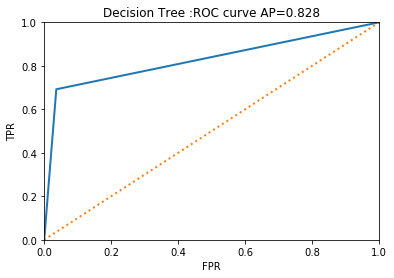

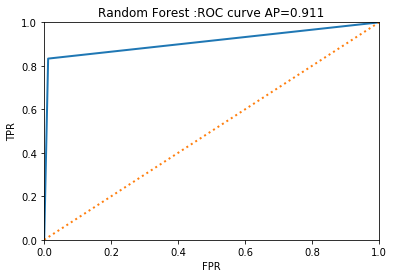

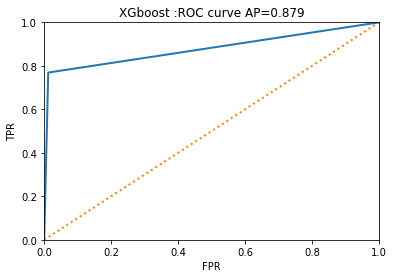

Average precision-recall score: 0.621
Average precision-recall score: 0.803
Average precision-recall score: 0.742


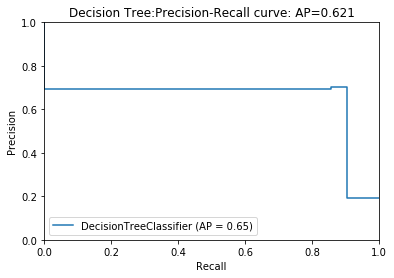

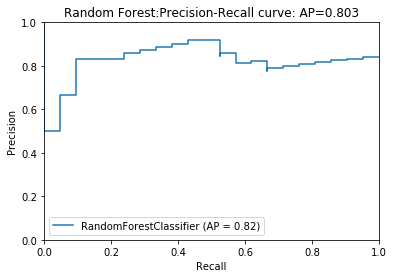

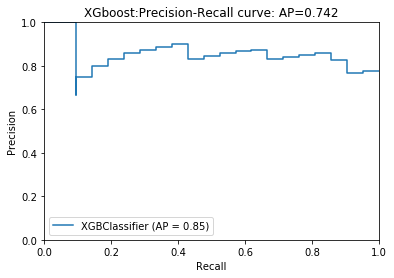

In [148]:
if __name__ == "__main__":
    print("測試：")
    tmp = esml()
    tmp.read_file(filename="./data/親權判決相關標註數據_rename.xlsx",remove_title=True)
    tmp.load_data(features = ["S"+str(i+1) for i in range (13)], label = "Result",drop_select=[0])
    tmp.split(split_rate = 0.25, random_state = 1)
    tmp.fit()
    tmp.accuracy()
    tmp.roc()
    tmp.prc()